<a href="https://colab.research.google.com/github/JhonyMitis/Analitica_datos/blob/master/Covid_19_Infected_Colombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis base de datos del covid-19

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from joblib import dump

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor

from scipy.stats import mode
from datetime import date

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


In [0]:
#Clase t-SNE
class tsne_map(BaseEstimator, TransformerMixin):
    def __init__(self, n_components, perplexity, n_neighbors):
        self.n_components = n_components
        self.perplexity = perplexity
        self.n_neighbors = n_neighbors
        return None
        
    def fit(self, X, *_):
        red = TSNE(n_components = self.n_components, perplexity = self.perplexity)
        z = red.fit_transform(X)
        
        self.neigh = KNeighborsRegressor(n_neighbors = self.n_neighbors)
        self.neigh.fit(X, z)
        return self
    
    def transform(self, X):
        return self.neigh.predict(X)
    
    def fit_transform(self, X, *_):
        self.fit(X)
        red = TSNE(n_components = self.n_components, perplexity = self.perplexity)
        return self.transform(X)

In [18]:
# Novel
csv_path_link = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'

# Kaggle
#csv_path_link = 'https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#time_series_covid_19_confirmed.csv'

Xdata = pd.read_csv(csv_path_link)
Xdata.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43


In [19]:
def window(serie, w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf].reshape(1,-1)
    pi += 1
    pf += 1
    while pf+1 <= serie.shape[0]:
        X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
        y = np.append(y,serie[pf].reshape(1,-1),axis=0)
        pi += 1
        pf += 1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

#Contagios acumulados
serie = np.array(Xdata.iloc[
    np.where(Xdata[Xdata.columns[1]] == 'Colombia')[0][0], 4:])

#Contagios por día
serie_d = np.append(0, np.diff(serie))

#Ventaneo
w = 5
X,y = window(serie, w)
Xd,yd = window(serie_d, w)

print('Serie:', serie.shape)
print('X:', X.shape)
print('y:', y.shape)
print('Xd:', Xd.shape)
print('Xd:', yd.shape)

Serie: (109,)
X: (104, 5)
y: (104, 1)
Xd: (104, 5)
Xd: (104, 1)


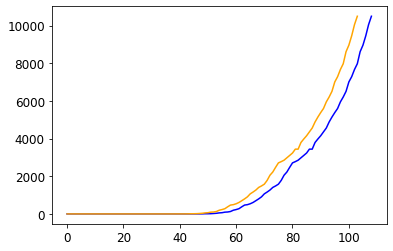

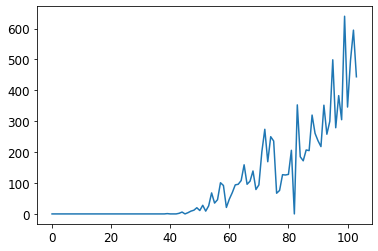

In [20]:
# Plotendo la curva

plt.plot(serie, 'b')
plt.plot(y, 'orange')
plt.figure()
plt.plot(yd)
plt.show()

# Análisis Exploratorio

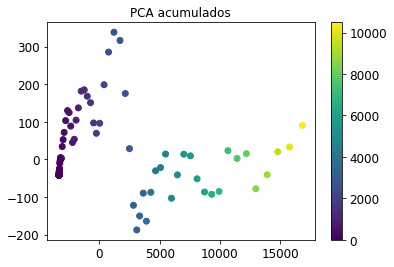

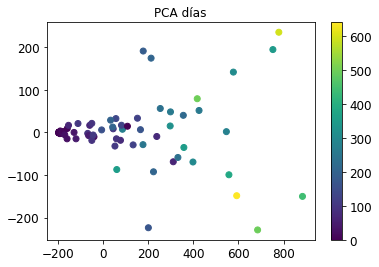

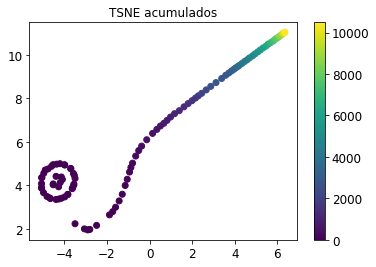

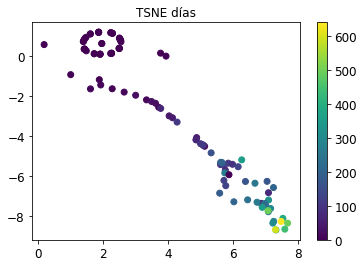

In [21]:
red_pca = PCA(n_components=None, 
              copy=True, 
              whiten=False, 
              svd_solver='auto', 
              tol=0.0, 
              iterated_power='auto', 
              random_state=None)

red_d_pca = PCA(n_components=None, 
              copy=True, 
              whiten=False, 
              svd_solver='auto', 
              tol=0.0, 
              iterated_power='auto', 
              random_state=None)

red_tsne = TSNE(n_components=2, 
                perplexity=30.0, 
                early_exaggeration=12.0, 
                learning_rate=200.0, 
                n_iter=1000, 
                n_iter_without_progress=300, 
                min_grad_norm=1e-07, 
                metric='euclidean', 
                init='random', 
                verbose=0, 
                random_state=None, 
                method='barnes_hut', 
                angle=0.5, 
                n_jobs=None)

red_d_tsne = TSNE(n_components=2, 
                perplexity=30.0, 
                early_exaggeration=12.0, 
                learning_rate=200.0, 
                n_iter=1000, 
                n_iter_without_progress=300, 
                min_grad_norm=1e-07, 
                metric='euclidean', 
                init='random', 
                verbose=0, 
                random_state=None, 
                method='barnes_hut', 
                angle=0.5, 
                n_jobs=None)

z_pca = red_pca.fit_transform(X)
zd_pca = red_d_pca.fit_transform(Xd)
z_tsne = red_tsne.fit_transform(X)
zd_tsne = red_d_tsne.fit_transform(Xd)

plt.figure()
plt.scatter(z_pca[:,0],z_pca[:,1], c=y[:,0])
plt.colorbar()
plt.title('PCA acumulados')

plt.figure()
plt.scatter(zd_pca[:,0],zd_pca[:,1], c=yd[:,0])
plt.colorbar()
plt.title('PCA días')

plt.figure()
plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y[:,0])
plt.colorbar()
plt.title('TSNE acumulados')

plt.figure()
plt.scatter(zd_tsne[:,0],zd_tsne[:,1], c=yd[:,0])
plt.colorbar()
plt.title('TSNE días')

plt.show()

Se pretende ajustar los hiperparámetros de algunos regresores lineales:

* Regresor lineal (mínimos cuadrados o máxima verisimilitud)
* Regresor Ridge (Regresión bayesiana al ruido isotrópico o regularización de tikonov)
* Regresor Lasso (en vez de norma 2, pone norma 1)
* ElasticNet (mezcla de las 2 normas)
* Kernel Ridge (aplica kernel trick)

Esto con el fin de poder realizar predicciones en el ventaneo anteriormente hecho, y así, estimar el valor del día siguiente de cada una de las ventanas.

A continuación se profundiza en el funcionamiento de cada uno de estos regresores.

### Regresor Lineal

Este regresor ajusta un modelo con con coeficientes $\theta = ({\theta}_{1}, ...,{\theta}_{p})$ para minimizar la suma residual de cuadrados entre los objetvos observados en el dataset, y los objetivos predichos por la aproximación lineal.

La salida estimada de este regresor se da por 

\begin{equation}
    \hat{y} = F(X|\theta) = X\theta = {\theta}_{0}+{\theta}_{1}{x}_{1}+{\theta}_{2}{x}_{2}+...+{\theta}_{n}{x}_{n}
\end{equation}


* $\hat{y}$ es el valor predicho
* n es el número de características
* ${x}_{i}$ es el valor de la iésima característica
* ${\theta}_{j}$ es el parámetro jotaésimo del modelo (incluyendo el término de sesgo ${\theta}_{0}$ y los pesos de las características ${\theta}_{1},{\theta}_{2},...,{\theta}_{n}$)

Para entrenar el modelo, se debe tener una medida que describa que tan bien se está ajustando el conjunto de entrenamiento. Para esto se usa el Root Mean Square Error (RMSE), y se busca un $\theta$ que minimice este valor, para eso, solo se debe minimizar el Mean Square Error (MSE)

\begin{equation}
    MSE(X,{h}_{\theta})=MSE(\theta)=\frac{1}{m}\sum_{i=1}^{m}(\theta^{T}x^{(i)}-y^{(i)})^{2}
\end{equation}

El error se calcula como ${{\left\|y - \hat{y}\right\|}_{2}}^{2}$

La función de coste se da como ${\theta}^{*} = \underset{min}{arg} l(y, f(X(\theta))$

Para encontrar el $\theta$ que minimice la función de costo, se utilizan mínimos cuadrados, si el modelo lineal tiene un error, se usa la máxima verosimilitud, ambos dan como resultado $\theta = {({X}^{T}X)}^{-1}{X}^{T}y$

### Regresor Ridge

Es una versión regularizada de la regresión lineal, se añade un término de regularización a la función de costo igual a $\alpha \sum_{i=1}^{n} {\theta}_{i}^{2}$ que también se puede ver como $\alpha{{\left\|\theta\right\|}_{2}}^{2}$ también llamado regularización Tikonov. Esto fuerza al modelo, no solo a ajustar los datos, sino a mantener los pesos del modelo lo más pequeños que sea posible. El término de regularización debe agregarse solamente a la función de costo durante el entrenamiento. Una vez que el modelo está entrenado, se quiere evaluar el rendimiento del modelos usando la medida de rendimiento no-regularizada.

El hiperparámetro $\alpha$ controla cuánto se quiere regularizar el modelo. Si $\alpha=0$, entonces la Ridge Regression es simplemente una Linear Regression. SI $\alpha$ es muy grande, todos los pesos estarán muy cerca de cero y el resultado es una línea delgada que va a través de la media de los datos.

\begin{equation}
        {\theta}^{*}=MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n} {\theta}_{i}^{2} = \underset{min}{arg} {{\left\|y - \hat{y}\right\|}_{2}}^{2} + \alpha{{\left\|\theta\right\|}_{2}}^{2}
\end{equation}

El término de bias ${\theta}_{0}$ no está regularizado (la suma comienza en i=1, y no en 0). Si se define **w** como el vector de pesos de características (${\theta}_{1}$ a ${\theta}_{n}$), entonces el término de regularización es igual a $\frac{1}{2}{{(\parallel w\parallel_2)}}^{2}$, donde ${\parallel w \parallel}_{2}$ representa la norma ${\ell}_{2}$ del vector de peso.

**Es importante escalar los datos antes de utilizar Ride Regression**

### Regresor Lasso

Añade un término de regularización a la función de coste, pero usa la norma ${\ell}_{1}$ del vector de pesos en lugar del cuadrado de la norma ${\ell}_{2}$

\begin{equation}
    {\theta}^{*} = MSE(\theta) + \alpha \sum_{i=1}^{n} \mid {\theta}_{i} \mid = \underset{min}{arg} {{\left\|y - \hat{y}\right\|}_{2}}^{2} + \alpha{\left\|\theta\right\|}_{1}
\end{equation}

### Elastic Net

Es un punto medio entre Ride Regression y Lasso Regression. El término de regularización es una mezcla de los términos de cada una de las regresiones y puede controlarse el radio de mezcla r.

\begin{equation}
    {\theta}^{*} = MSE(\theta) + r\alpha \sum_{i=1}^{n} \mid {\theta}_{i} \mid + \frac{1-r}{2}\alpha \sum_{i=1}^{n} {\theta_i}^{2} = \underset{min}{arg} {{\left\|y - \hat{y}\right\|}_{2}}^{2} + r\alpha{\left\|\theta\right\|}_{1} + \frac{1-r}{2}\alpha{{\left\|\theta\right\|}_{2}}^{2}
\end{equation}

### Kernel Ridge

Esta regresión combina **Ridge Regression** con el kernel trick

* Kernel Trick: permite operar en un espacio de características multidimensional sin calcular las coordenadas de los datos en ese espacio, sino simplemente calculando los productos internos entre las imágenes de todos los pares de datos en el espacio de características. $k(x,{x}^{\prime}) = \langle\varphi(x),\varphi({x}^{\prime})\rangle = {\varphi(x)}^{T} \varphi({x}^{\prime})$


Por lo tanto, aprende una función lineal en el espacio inducida por el kernel respectivo y los datos. Para kernels no lineales, esto corresponde a una función no lineal en el espacio original.

Como función de pérdida se usa el error al cuadrado.

# Contagios acumulados

In [0]:
steps = [
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', LinearRegression(fit_intercept = 'False'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', LinearRegression())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', Ridge())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', Lasso())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', ElasticNet())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'rbf'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'sigmoid'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'laplacian'))],
    
    
    #Con este se demora el gridsearch (1875 fits)
    [('scaler', StandardScaler()),
    ('rep', tsne_map(n_components = 2,  
                     perplexity = 30, 
                     n_neighbors = 3)),
    ('reg', KernelRidge(kernel = 'sigmoid'))]
    
    
]

params = [
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,10)     
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5)
    }, 
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__l1_ratio': np.linspace(0.1,1,5)
    }, 
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    }, 
    
    #con este se demora el gridsearch (1875 fits) 
    {#'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]), 
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    }
    
]


label_model = ['Linear', 'Linear fit', 'Ridge', 'Lasso', 'Elastic', 
               'Kernel rbf', 'Kernel sigmoid', 'Kernel laplacian']

Como son muy pocos datos, se debe hacer validación cruzada anidada

In [23]:
Niter = 10 #Número de particiones
mae = np.zeros((Niter, len(steps))) #Error absoluto
best_estimators = Niter*[len(steps)*[None]]
best_hyperparams = Niter*[len(steps)*[None]]

for j in range(Niter):
    
    print("Iteración %d/%d" %(j+1, Niter))
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X,y,test_size=0.3) #Xtrain(70%) ytrain(30%)
    
    #Recorre los modelos
    for r in range(len(steps)):
        
        grid_search = GridSearchCV(Pipeline(steps[r]), params[r],
                cv=5, verbose=5, scoring='neg_mean_absolute_error', n_jobs=4)
        
        #Entrenando
        grid_search.fit(Xtrain, ytrain)
        
        #Realizando predicción con el mejor modelo
        ypred = grid_search.best_estimator_.predict(Xtest)
        
        #Guardando el mejor modelo
        best_estimators[j][r] = grid_search.best_estimator_
        
        #Guardando los mejores hiperparámetros
        best_hyperparams[j][r] = grid_search.best_params_
        
        #Guardando error
        mae[j,r] = mean_absolute_error(ytest, ypred)
        
        print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r+1,len(steps)))
        print('mae:',mae[j,r])

        savedata = {
            'acc':mae,
            'best_models':best_estimators,
            'best_parameters':best_hyperparams,
              } 
        dump(savedata,'covid19_1.joblib')

Iteración 1/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 1/9
mae: 55.55495966261034
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 1/10-Modelo 2/9
mae: 55.55495966261034
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 1/10-Modelo 3/9
mae: 55.74852943091666
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 4/9
mae: 55.56418213530978
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished


it 1/10-Modelo 5/9
mae: 55.56418213530978
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 1/10-Modelo 6/9
mae: 40.441902012933014
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 7/9
mae: 41.713250938528496
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 8/9
mae: 37.55930419529719
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.2s finished


it 1/10-Modelo 9/9
mae: 20142.99984011477
Iteración 2/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 2/10-Modelo 1/9
mae: 65.40926402184543
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s


it 2/10-Modelo 2/9
mae: 65.40926402184543
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s


it 2/10-Modelo 3/9
mae: 65.54654583940504
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 112 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 2/10-Modelo 4/9
mae: 65.41735027968801
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 2/10-Modelo 5/9
mae: 65.41735027968801
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 2/10-Modelo 6/9
mae: 54.804368712880986
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 2/10-Modelo 7/9
mae: 68.64741559278445
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished


it 2/10-Modelo 8/9
mae: 46.62065473892084
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   31.9s finished


it 2/10-Modelo 9/9
mae: 232.30463081772936
Iteración 3/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 3/10-Modelo 1/9
mae: 69.32103637641087
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.1s


it 3/10-Modelo 2/9
mae: 69.32103637641087
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 3/10-Modelo 3/9
mae: 69.45186587699897
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 3/10-Modelo 4/9
mae: 69.32827597570093
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 5/9
mae: 69.32827597570093
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 3/10-Modelo 6/9
mae: 49.731651312601485
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 3/10-Modelo 7/9
mae: 70.29619441144806
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished


it 3/10-Modelo 8/9
mae: 41.67222224139742
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.0s finished


it 3/10-Modelo 9/9
mae: 37297.58588383122
Iteración 4/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 4/10-Modelo 1/9
mae: 83.85506099173712
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.1s


it 4/10-Modelo 2/9
mae: 83.85506099173712
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 4/10-Modelo 3/9
mae: 83.96956794118846
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 4/10-Modelo 4/9
mae: 83.86154784242552
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 5/9
mae: 83.86154784242552
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 4/10-Modelo 6/9
mae: 89.35838325787304
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 559 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 4/10-Modelo 7/9
mae: 65.67523274301743
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 536 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished


it 4/10-Modelo 8/9
mae: 62.26171495136231
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   31.9s finished


it 4/10-Modelo 9/9
mae: 1970.2329663528353
Iteración 5/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 5/10-Modelo 1/9
mae: 74.30280668474072
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.1s


it 5/10-Modelo 2/9
mae: 74.30280668474072
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.1s


it 5/10-Modelo 3/9
mae: 74.55597705796085
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 5/10-Modelo 4/9
mae: 74.31849381980271
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 536 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 5/9
mae: 74.31849381980271
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 527 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 5/10-Modelo 6/9
mae: 67.37092935533757
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 5/10-Modelo 7/9
mae: 61.834396098040635
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 8/9
mae: 70.39015262542968
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.5s finished


it 5/10-Modelo 9/9
mae: 526.5181200541459
Iteración 6/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 6/10-Modelo 1/9
mae: 62.60821195744406
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 2/9
mae: 62.60821195744406
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 6/10-Modelo 3/9
mae: 62.954884883120215
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 6/10-Modelo 4/9
mae: 62.63020105103393
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 5/9
mae: 62.63020105103393
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished


it 6/10-Modelo 6/9
mae: 125.569576920687
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.2s


it 6/10-Modelo 7/9
mae: 61.64562325862386
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished


it 6/10-Modelo 8/9
mae: 98.42073986629791
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   31.8s finished


it 6/10-Modelo 9/9
mae: 1356.4314896185074
Iteración 7/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 7/10-Modelo 1/9
mae: 79.65232766056863
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 7/10-Modelo 2/9
mae: 79.65232766056863
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 7/10-Modelo 3/9
mae: 79.71808431257867
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.1s


it 7/10-Modelo 4/9
mae: 79.65600037812948
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 536 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 7/10-Modelo 5/9
mae: 79.65600037812948
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 523 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 6/9
mae: 73.79421588772666
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 7/10-Modelo 7/9
mae: 94.76379225852104
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 538 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 7/10-Modelo 8/9
mae: 54.98150800312744
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.4s finished


it 7/10-Modelo 9/9
mae: 4291.686854367379
Iteración 8/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 8/10-Modelo 1/9
mae: 75.79280403094693
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 2/9
mae: 75.79280403094693
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 8/10-Modelo 3/9
mae: 75.86135188433207
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s


it 8/10-Modelo 4/9
mae: 75.79674343384067
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 8/10-Modelo 5/9
mae: 75.79674343384067
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 8/10-Modelo 6/9
mae: 90.08722151648735
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 557 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 8/10-Modelo 7/9
mae: 60.16619224111662
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 8/9
mae: 58.93572060411423
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.1s finished


it 8/10-Modelo 9/9
mae: 1846.9658371549167
Iteración 9/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 9/10-Modelo 1/9
mae: 74.76851181401274
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 2/9
mae: 74.76851181401274
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 9/10-Modelo 3/9
mae: 74.83662895575617
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 9/10-Modelo 4/9
mae: 74.77272360512822
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 557 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 9/10-Modelo 5/9
mae: 74.77272360512822
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 9/10-Modelo 6/9
mae: 104.04586785459432
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 9/10-Modelo 7/9
mae: 96.31516646793371
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 527 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 8/9
mae: 62.29369366349499
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.2s finished


it 9/10-Modelo 9/9
mae: 42616.99188129304
Iteración 10/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 10/10-Modelo 1/9
mae: 52.77628565011261
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.1s


it 10/10-Modelo 2/9
mae: 52.77628565011261
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 10/10-Modelo 3/9
mae: 52.81455344885652
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 10/10-Modelo 4/9
mae: 52.77859199146669
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 10/10-Modelo 5/9
mae: 52.77859199146669
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 10/10-Modelo 6/9
mae: 107.45658125425565
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 10/10-Modelo 7/9
mae: 68.86008548630225
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished


it 10/10-Modelo 8/9
mae: 79.85065911364957
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.1s finished


it 10/10-Modelo 9/9
mae: 2128.7715292918556


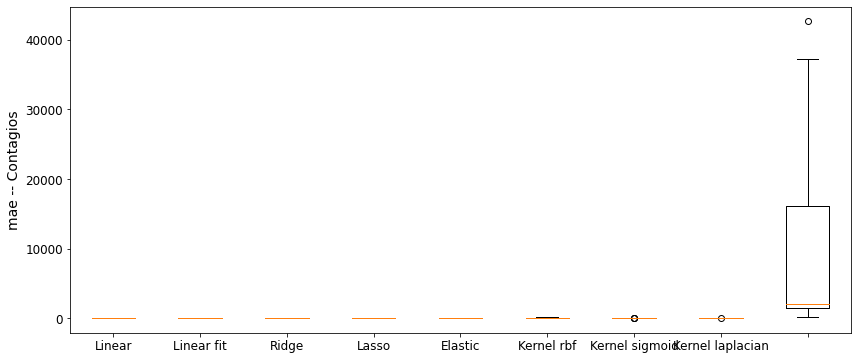

array([[5.55549597e+01, 5.55549597e+01, 5.57485294e+01, 5.55641821e+01,
        5.55641821e+01, 4.04419020e+01, 4.17132509e+01, 3.75593042e+01,
        2.01429998e+04],
       [6.54092640e+01, 6.54092640e+01, 6.55465458e+01, 6.54173503e+01,
        6.54173503e+01, 5.48043687e+01, 6.86474156e+01, 4.66206547e+01,
        2.32304631e+02],
       [6.93210364e+01, 6.93210364e+01, 6.94518659e+01, 6.93282760e+01,
        6.93282760e+01, 4.97316513e+01, 7.02961944e+01, 4.16722222e+01,
        3.72975859e+04],
       [8.38550610e+01, 8.38550610e+01, 8.39695679e+01, 8.38615478e+01,
        8.38615478e+01, 8.93583833e+01, 6.56752327e+01, 6.22617150e+01,
        1.97023297e+03],
       [7.43028067e+01, 7.43028067e+01, 7.45559771e+01, 7.43184938e+01,
        7.43184938e+01, 6.73709294e+01, 6.18343961e+01, 7.03901526e+01,
        5.26518120e+02],
       [6.26082120e+01, 6.26082120e+01, 6.29548849e+01, 6.26302011e+01,
        6.26302011e+01, 1.25569577e+02, 6.16456233e+01, 9.84207399e+01,
        1.3

In [24]:
plt.figure(figsize=(14,6))
plt.boxplot(mae)
plt.xticks(ticks=np.arange(len(steps))+1,
                      labels=label_model)
plt.ylabel('mae -- Contagios')
plt.show()
mae

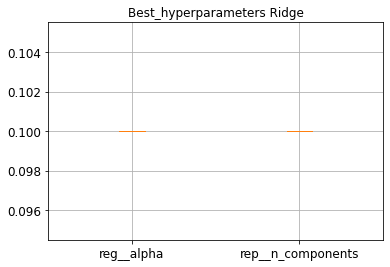

Modes=  [0.1 0.1]


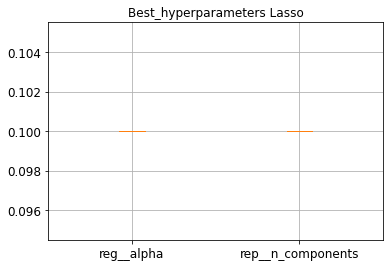

Modes=  [0.1 0.1]


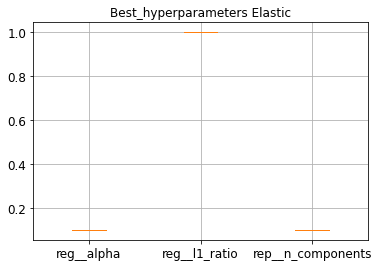

Modes=  [0.1 1.  0.1]


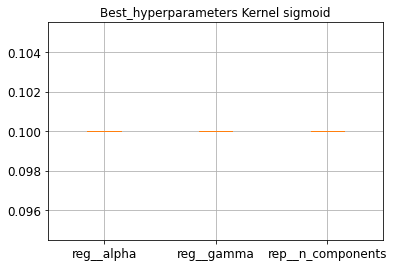

Modes=  [0.1 0.1 0.1]


In [36]:
modelo = [2, 3, 4, 6] #Linear, Lasso, Elastic Net, Kernel Ridge Sigmoide PCA

def mode_hyperpar(modelo):    

    nh = len(best_hyperparams[0][modelo])
    hyperpar = np.zeros((Niter, nh))

    for i in range(Niter):
        for j in range(nh):
            hyperpar[i,j] = best_hyperparams[i][modelo].get(list(best_hyperparams[i][modelo].keys())[j])

    plt.boxplot(hyperpar)
    plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperparams[0][modelo].keys()))
    plt.title('Best_hyperparameters ' + label_model[modelo])
    plt.grid()
    plt.show()
    
    mode_hyper = mode(hyperpar,axis=0)[0][0]
    print("Modes= ", mode_hyper)
    
    return hyperpar, mode_hyper, nh

hyperpar_0, mode_hyper_0, nh_0 = mode_hyperpar(modelo[0])
hyperpar_1, mode_hyper_1, nh_1 = mode_hyperpar(modelo[1])
hyperpar_2, mode_hyper_2, nh_2 = mode_hyperpar(modelo[2])
hyperpar_3, mode_hyper_3, nh_3 = mode_hyperpar(modelo[3])

In [38]:
def train_model(modelo, nh, mode_hyper):
    model_f = Pipeline(steps[modelo])
    paramsf = params[modelo]
    hyperl = list(params[modelo].keys())

    for j in range(nh):
        paramsf[hyperl[j]] = mode_hyper[j]

    return model_f, paramsf



linear, params_0 = train_model(modelo[0], nh_0, mode_hyper_0)
linear.set_params(**params_0)
linear.fit(X,y)

lasso, params_1 = train_model(modelo[1], nh_1, mode_hyper_1)
lasso.set_params(**params_1)
lasso.fit(X,y)

elastic, params_2 = train_model(modelo[2], nh_2, mode_hyper_2)
elastic.set_params(**params_2)
elastic.fit(X,y)

kernel, params_3 = train_model(modelo[3], nh_3, mode_hyper_3)
kernel.set_params(**params_3)
kernel.fit(X,y)



Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.1,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=0.1,
                             kernel='sigmoid', kernel_params=None))],
         verbose=False)

In [40]:
y_pred_lin = linear.predict(serie[len(serie)-w:].reshape(1,-1))[0]
y_pred_las = lasso.predict(serie[len(serie)-w:].reshape(1,-1))[0]
y_pred_ela = elastic.predict(serie[len(serie)-w:].reshape(1,-1))[0]
y_pred_ker = kernel.predict(serie[len(serie)-w:].reshape(1,-1))[0]

print('Predicción contagiados covid19 ',date.today(),
      '\nLinear:',y_pred_lin,
      '\nLasso:',y_pred_las,
      '\nElastic Net: ', y_pred_ela,
      '\nKernel Ridge (sigmoid): ', y_pred_ker)

Predicción contagiados covid19  2020-05-10 
Linear: [11086.09212428] 
Lasso: 11087.7295825719 
Elastic Net:  9667.447729186148 
Kernel Ridge (sigmoid):  [11461.42235453]


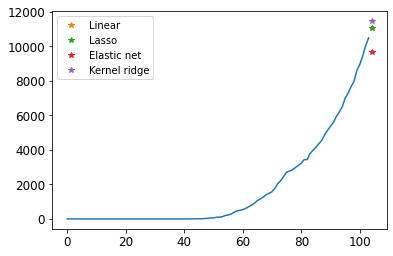

In [41]:
plt.plot(y)
plt.plot(len(y),y_pred_lin, '*', label='Linear')
plt.plot(len(y),y_pred_las, '*', label='Lasso')
plt.plot(len(y),y_pred_ela, '*', label='Elastic net')
plt.plot(len(y),y_pred_ker, '*', label='Kernel ridge')

plt.legend(loc='best')
plt.show()

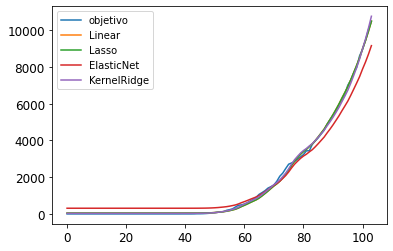

In [43]:
plt.plot(y, label='objetivo')
plt.plot(linear.predict(X), label='Linear')
plt.plot(lasso.predict(X), label='Lasso')
plt.plot(elastic.predict(X), label='ElasticNet')
plt.plot(kernel.predict(X), label='KernelRidge')


plt.legend(loc='best')
plt.show()

# Contagios por días

In [0]:
steps = [
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', LinearRegression(fit_intercept = 'False'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', LinearRegression())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', Ridge())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', Lasso())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', ElasticNet())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'rbf'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'sigmoid'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'laplacian'))],
    
    
    #Con este se demora el gridsearch (1875 fits)
    [('scaler', StandardScaler()),
    ('rep', tsne_map(n_components = 2,  
                     perplexity = 30, 
                     n_neighbors = 3)),
    ('reg', KernelRidge(kernel = 'sigmoid'))]
    
    
]

params = [
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,10)     
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5)
    }, 
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__l1_ratio': np.linspace(0.1,1,5)
    }, 
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    }, 
    
    #con este se demora el gridsearch (1875 fits) 
    {#'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]), 
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    }
    
]


label_model = ['Linear', 'Linear fit', 'Ridge', 'Lasso', 'Elastic', 
               'Kernel rbf', 'Kernel sigmoid', 'Kernel laplacian']

In [59]:
Niter = 10 #Número de particiones
maed = np.zeros((Niter, len(steps))) #Error absoluto
best_estimatorsd = Niter*[len(steps)*[None]]
best_hyperparamsd = Niter*[len(steps)*[None]]

for j in range(Niter):
    
    print("Iteración %d/%d" %(j+1, Niter))
    Xtraind, Xtestd, ytraind, ytestd = train_test_split(
        Xd,yd,test_size=0.3) #Xtrain(70%) ytrain(30%)
    
    #Recorre los modelos
    for r in range(len(steps)):
        
        grid_search = GridSearchCV(Pipeline(steps[r]), params[r],cv=5, verbose=5, scoring='neg_mean_absolute_error', n_jobs=4)
        
        #Entrenando
        grid_search.fit(Xtraind, ytraind)
        
        #Realizando predicción con el mejor modelo
        ypredd = grid_search.best_estimator_.predict(Xtestd)
        
        #Guardando el mejor modelo
        best_estimatorsd[j][r] = grid_search.best_estimator_
        
        #Guardando los mejores hiperparámetros
        best_hyperparamsd[j][r] = grid_search.best_params_
        
        #Guardando error
        maed[j,r] = mean_absolute_error(ytestd, ypredd)
        
        print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
        print('mae:',mae[j,r])

        savedata = {
            'acc':maed,
            'best_models':best_estimatorsd,
            'best_parameters':best_hyperparamsd,
              } 
        dump(savedata,'covid19_2.joblib')

Iteración 1/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 0/9
mae: 55.55495966261034
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 1/10-Modelo 1/9
mae: 55.55495966261034
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 2/9
mae: 55.74852943091666
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 3/9
mae: 55.56418213530978
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 472 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 4/9
mae: 55.56418213530978
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 5/9
mae: 40.441902012933014
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 1/10-Modelo 6/9
mae: 41.713250938528496
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished


it 1/10-Modelo 7/9
mae: 37.55930419529719
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.2s finished


it 1/10-Modelo 8/9
mae: 20142.99984011477
Iteración 2/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 2/10-Modelo 0/9
mae: 65.40926402184543
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 2/10-Modelo 1/9
mae: 65.40926402184543
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 2/10-Modelo 2/9
mae: 65.54654583940504
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 2/10-Modelo 3/9
mae: 65.41735027968801
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished


it 2/10-Modelo 4/9
mae: 65.41735027968801
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 536 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.2s


it 2/10-Modelo 5/9
mae: 54.804368712880986
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 529 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 2/10-Modelo 6/9
mae: 68.64741559278445
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 2/10-Modelo 7/9
mae: 46.62065473892084
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.3s finished


it 2/10-Modelo 8/9
mae: 232.30463081772936
Iteración 3/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 3/10-Modelo 0/9
mae: 69.32103637641087


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 3/10-Modelo 1/9
mae: 69.32103637641087
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 3/10-Modelo 2/9
mae: 69.45186587699897
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 3/10-Modelo 3/9
mae: 69.32827597570093
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 4/9
mae: 69.32827597570093
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished


it 3/10-Modelo 5/9
mae: 49.731651312601485
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 576 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.5s finished


it 3/10-Modelo 6/9
mae: 70.29619441144806
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 7/9
mae: 41.67222224139742
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   31.9s finished


it 3/10-Modelo 8/9
mae: 37297.58588383122
Iteración 4/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 4/10-Modelo 0/9
mae: 83.85506099173712
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 4/10-Modelo 1/9
mae: 83.85506099173712
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 4/10-Modelo 2/9
mae: 83.96956794118846
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 4/10-Modelo 3/9
mae: 83.86154784242552
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 559 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 4/9
mae: 83.86154784242552
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 527 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 5/9
mae: 89.35838325787304
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 6/9
mae: 65.67523274301743
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 520 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 4/10-Modelo 7/9
mae: 62.26171495136231
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.0s finished


it 4/10-Modelo 8/9
mae: 1970.2329663528353
Iteración 5/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 5/10-Modelo 0/9
mae: 74.30280668474072
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 5/10-Modelo 1/9
mae: 74.30280668474072
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 5/10-Modelo 2/9
mae: 74.55597705796085
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 5/10-Modelo 3/9
mae: 74.31849381980271
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 5/10-Modelo 4/9
mae: 74.31849381980271
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 557 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 5/10-Modelo 5/9
mae: 67.37092935533757
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 527 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 5/10-Modelo 6/9
mae: 61.834396098040635
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 7/9
mae: 70.39015262542968
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.2s finished


it 5/10-Modelo 8/9
mae: 526.5181200541459
Iteración 6/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 6/10-Modelo 0/9
mae: 62.60821195744406
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 6/10-Modelo 1/9
mae: 62.60821195744406
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.2s


it 6/10-Modelo 2/9
mae: 62.954884883120215
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 3/9
mae: 62.63020105103393
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 576 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished


it 6/10-Modelo 4/9
mae: 62.63020105103393
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished


it 6/10-Modelo 5/9
mae: 125.569576920687
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 560 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 6/10-Modelo 6/9
mae: 61.64562325862386
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 557 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 7/9
mae: 98.42073986629791
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.0s finished


it 6/10-Modelo 8/9
mae: 1356.4314896185074
Iteración 7/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 7/10-Modelo 0/9
mae: 79.65232766056863
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 7/10-Modelo 1/9
mae: 79.65232766056863
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.1s


it 7/10-Modelo 2/9
mae: 79.71808431257867
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s


it 7/10-Modelo 3/9
mae: 79.65600037812948
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 336 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 4/9
mae: 79.65600037812948
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 5/9
mae: 73.79421588772666
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 6/9
mae: 94.76379225852104
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 7/10-Modelo 7/9
mae: 54.98150800312744
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   31.9s finished


it 7/10-Modelo 8/9
mae: 4291.686854367379
Iteración 8/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 8/10-Modelo 0/9
mae: 75.79280403094693
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 8/10-Modelo 1/9
mae: 75.79280403094693
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s


it 8/10-Modelo 2/9
mae: 75.86135188433207
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 112 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 8/10-Modelo 3/9
mae: 75.79674343384067
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 472 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 8/10-Modelo 4/9
mae: 75.79674343384067
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 527 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s


it 8/10-Modelo 5/9
mae: 90.08722151648735
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 448 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 8/10-Modelo 6/9
mae: 60.16619224111662
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 7/9
mae: 58.93572060411423
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.0s finished


it 8/10-Modelo 8/9
mae: 1846.9658371549167
Iteración 9/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 9/10-Modelo 0/9
mae: 74.76851181401274
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 9/10-Modelo 1/9
mae: 74.76851181401274
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 9/10-Modelo 2/9
mae: 74.83662895575617
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 9/10-Modelo 3/9
mae: 74.77272360512822
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 4/9
mae: 74.77272360512822
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 9/10-Modelo 5/9
mae: 104.04586785459432
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 544 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 9/10-Modelo 6/9
mae: 96.31516646793371
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 7/9
mae: 62.29369366349499
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.1s finished


it 9/10-Modelo 8/9
mae: 42616.99188129304
Iteración 10/10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 10/10-Modelo 0/9
mae: 52.77628565011261
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 10/10-Modelo 1/9
mae: 52.77628565011261
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 10/10-Modelo 2/9
mae: 52.81455344885652
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 10/10-Modelo 3/9
mae: 52.77859199146669
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 10/10-Modelo 4/9
mae: 52.77859199146669
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 10/10-Modelo 5/9
mae: 107.45658125425565
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 10/10-Modelo 6/9
mae: 68.86008548630225
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished


it 10/10-Modelo 7/9
mae: 79.85065911364957
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   32.0s finished


it 10/10-Modelo 8/9
mae: 2128.7715292918556


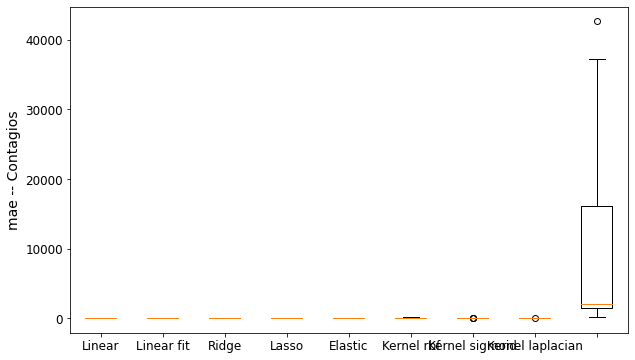

array([[5.55549597e+01, 5.55549597e+01, 5.57485294e+01, 5.55641821e+01,
        5.55641821e+01, 4.04419020e+01, 4.17132509e+01, 3.75593042e+01,
        2.01429998e+04],
       [6.54092640e+01, 6.54092640e+01, 6.55465458e+01, 6.54173503e+01,
        6.54173503e+01, 5.48043687e+01, 6.86474156e+01, 4.66206547e+01,
        2.32304631e+02],
       [6.93210364e+01, 6.93210364e+01, 6.94518659e+01, 6.93282760e+01,
        6.93282760e+01, 4.97316513e+01, 7.02961944e+01, 4.16722222e+01,
        3.72975859e+04],
       [8.38550610e+01, 8.38550610e+01, 8.39695679e+01, 8.38615478e+01,
        8.38615478e+01, 8.93583833e+01, 6.56752327e+01, 6.22617150e+01,
        1.97023297e+03],
       [7.43028067e+01, 7.43028067e+01, 7.45559771e+01, 7.43184938e+01,
        7.43184938e+01, 6.73709294e+01, 6.18343961e+01, 7.03901526e+01,
        5.26518120e+02],
       [6.26082120e+01, 6.26082120e+01, 6.29548849e+01, 6.26302011e+01,
        6.26302011e+01, 1.25569577e+02, 6.16456233e+01, 9.84207399e+01,
        1.3

In [60]:
plt.figure(figsize=(10,6))
plt.boxplot(mae)
plt.xticks(ticks=np.arange(len(steps))+1,
                      labels=label_model)
plt.ylabel('mae -- Contagios')
plt.show()
mae

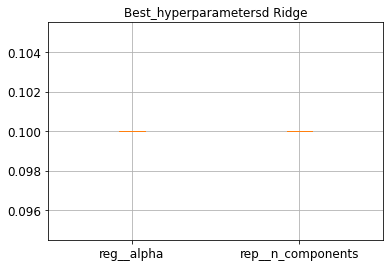

Modes=  [0.1 0.1]


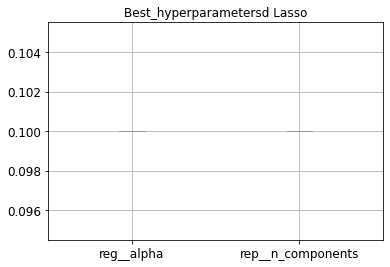

Modes=  [0.1 0.1]


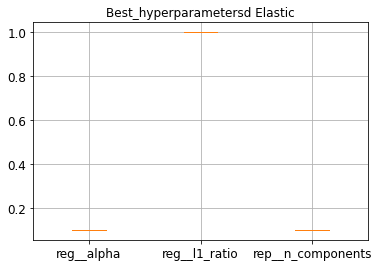

Modes=  [0.1 1.  0.1]


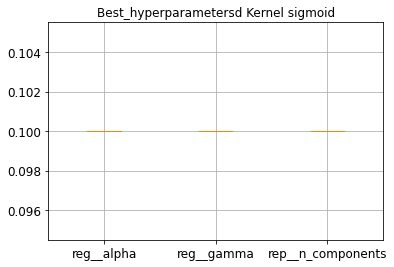

Modes=  [0.1 0.1 0.1]


In [61]:
hyperpard_0, mode_hyperd_0, nhd_0 = mode_hyperpard(modelo[0])
hyperpard_1, mode_hyperd_1, nhd_1 = mode_hyperpard(modelo[1])
hyperpard_2, mode_hyperd_2, nhd_2 = mode_hyperpard(modelo[2])
hyperpard_3, mode_hyperd_3, nhd_3 = mode_hyperpard(modelo[3])

In [63]:
lassod, paramsd_1 = train_model(modelo[1], nh_1, mode_hyper_1)
lassod.set_params(**params_1)
lassod.fit(X,y)

elasticd, paramsd_2 = train_model(modelo[2], nh_2, mode_hyper_2)
elasticd.set_params(**params_2)
elasticd.fit(X,y)

kerneld, paramsd_3 = train_model(modelo[3], nh_3, mode_hyper_3)
kerneld.set_params(**params_3)
kerneld.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.1,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=0.1,
                             kernel='sigmoid', kernel_params=None))],
         verbose=False)

In [64]:
y_pred_lasd = lassod.predict(serie_d[len(serie_d)-w:].reshape(1,-1))[0]
y_pred_elad = elasticd.predict(serie_d[len(serie_d)-w:].reshape(1,-1))[0]
y_pred_kerd = kerneld.predict(serie_d[len(serie_d)-w:].reshape(1,-1))[0]

print('Predicción contagiados covid19 ',date.today(),
      '\nLasso:',y_pred_lasd,
      '\nElastic Net: ', y_pred_elad,
      '\nKernel Ridge (sigmoid): ', y_pred_kerd)

Predicción contagiados covid19  2020-05-10 
Lasso: 635.2199239535016 
Elastic Net:  809.969719530191 
Kernel Ridge (sigmoid):  [705.89808997]


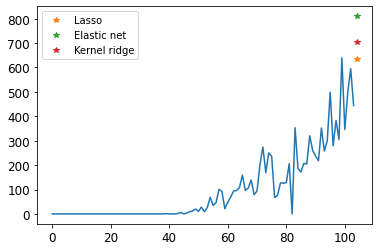

In [66]:
plt.plot(yd)
plt.plot(len(y),y_pred_lasd, '*', label='Lasso')
plt.plot(len(y),y_pred_elad, '*', label='Elastic net')
plt.plot(len(y),y_pred_kerd, '*', label='Kernel ridge')

plt.legend(loc='best')
plt.show()

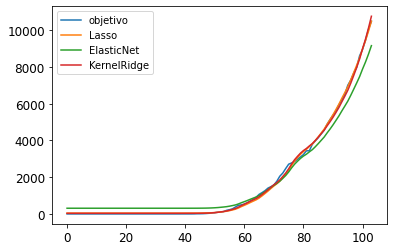

In [69]:
plt.plot(y, label='objetivo')
plt.plot(lassod.predict(X), label='Lasso')
plt.plot(elasticd.predict(X), label='ElasticNet')
plt.plot(kerneld.predict(X), label='KernelRidge')


plt.legend(loc='best')
plt.show()